# Suffix Algorithm Performance Analysis

This notebook analyzes the `benchmark_results.csv` file generated by `benchmark.py`.

The goal is to visually analyze the empirical performance of our "from scratch" suffix algorithms, as required by the project deliverables. We will generate three primary graphs:

1.  **Construction Time vs. Input Size (n)**
2.  **Memory Usage vs. Input Size (n)**
3.  **Query Time vs. Pattern Length (m)**

## Phase 1: Setup and Imports

First, we import all necessary libraries and set up our global plotting style. We'll use:
* `pandas` for data loading and manipulation.
* `seaborn` and `matplotlib` for plotting.
* `os` to handle file paths.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# This is a special Jupyter command to make plots appear in the notebook
%matplotlib inline

# Set a nice default style for our plots
sns.set_theme(style="whitegrid")

print("Libraries imported.")

Libraries imported.


## Phase 2: Data Loading and Preparation

Next, we load our results CSV into a pandas DataFrame. We'll also define constants for the dataset we want to analyze and the directory to save our final graphs.

In [2]:
# --- Configuration ---
CSV_FILE = "benchmark_results.csv"
OUTPUT_DIR = "graphs"

# We'll use our main E. coli genome for all graphs to be consistent
DATASET_TO_PLOT = "GCA_000005845.2_ASM584v2_genomic.fna"

# --- Load Data ---
if not os.path.exists(CSV_FILE):
    print(f"Error: {CSV_FILE} not found. Please run benchmark.py first.")
else:
    df = pd.read_csv(CSV_FILE)
    print("Benchmark data loaded successfully.")

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# --- Inspect the Data ---
# df.head() gives us the first 5 rows to confirm our data looks right
print("\nData Head:")
print(df.head())

# df.info() gives us a summary of all columns and data types
print("\nData Info:")
df.info()

Benchmark data loaded successfully.

Data Head:
         algorithm                          dataset_name  text_length_n  \
0         sa_naive  GCA_000005845.2_ASM584v2_genomic.fna           1000   
1         st_naive  GCA_000005845.2_ASM584v2_genomic.fna           1000   
2  sa_manber_myers  GCA_000005845.2_ASM584v2_genomic.fna           1000   
3  sa_manber_query  GCA_000005845.2_ASM584v2_genomic.fna           1000   
4   sa_naive_query  GCA_000005845.2_ASM584v2_genomic.fna           1000   

   pattern_length_m   metric_type  time_sec  memory_bytes  
0                 0  construction  0.000546             0  
1                 0  construction  0.567705     189923328  
2                 0  construction  0.002764        131072  
3                 7         query  0.000015             0  
4                 7         query  0.000011             0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column            No

## Graph 1: Construction Time vs. Input Size (n)

This graph answers the question: **"How does algorithm runtime scale with input size?"**

We will plot `time_sec` vs. `text_length_n` for all algorithms where `metric == "construction"`.

### Justification for Log-Log Scale

As we discussed, a simple linear plot will make the `sa_naive` data (which only ran on small inputs) invisible. To solve this, we use a **log-log scale**:

1.  **Visualizes All Data:** It compresses the axes, allowing us to see the data for `n=1000` and `n=100000` on the same plot.
2.  **Proves Complexity:** On a log-log graph, polynomial algorithms (like $O(n^2)$) appear as **straight lines**. The **slope of the line *is* the complexity**. This will visually prove the difference between our quadratic naive algorithm and our $O(n \log n)$ Manber-Myers algorithm.

Graph 1 saved to graphs/graph1_construction_time.png


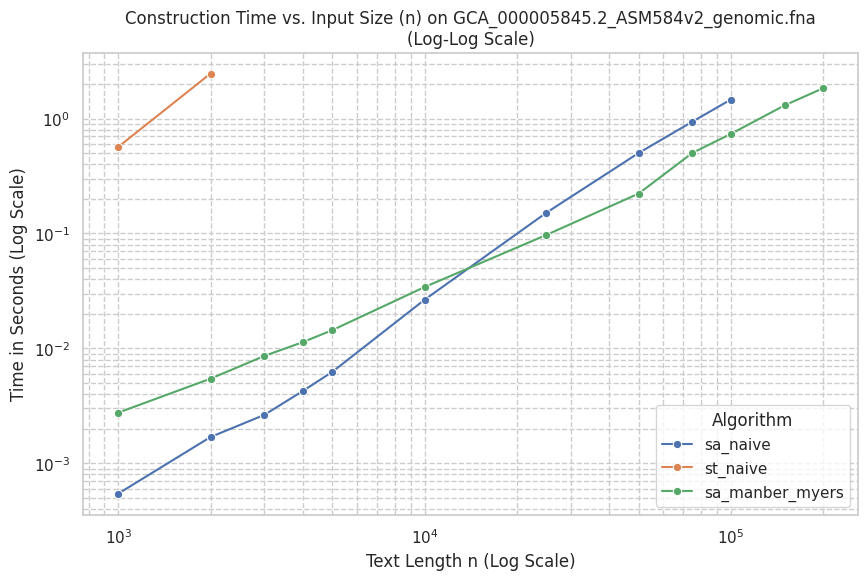

In [3]:
# Filter the DataFrame to get only construction data for our main dataset
# --- AFTER ---
data_g1 = df[
    (df["metric_type"] == "construction") &
    (df["dataset_name"] == DATASET_TO_PLOT) 
].copy()

# Create the plot
plt.figure(figsize=(10, 6))
plot_g1 = sns.lineplot(
    data=data_g1,
    x="text_length_n",
    y="time_sec",
    hue="algorithm",  # Creates a different line for each algorithm
    marker="o"        # Adds a dot for each data point
)

# --- Set the Log-Log Scale ---
plot_g1.set(xscale="log", yscale="log")

# --- Set Labels and Title ---
plt.title(f"Construction Time vs. Input Size (n) on {DATASET_TO_PLOT}\n(Log-Log Scale)")
plt.xlabel("Text Length n (Log Scale)")
plt.ylabel("Time in Seconds (Log Scale)")
plt.grid(True, which="both", ls="--")
plt.legend(title="Algorithm")

# Save the figure and show it
output_path = os.path.join(OUTPUT_DIR, "graph1_construction_time.png")
plt.savefig(output_path)
print(f"Graph 1 saved to {output_path}")
plt.show()

### Analysis of Construction Time Graph

This log-log graph clearly illustrates the crucial difference between **theoretical complexity** (Big-O) and **practical performance** (constant factors).

#### 1. Why `st_naive` ($O(n^2)$) is the Slowest

This is the most dramatic finding. Although `st_naive` is theoretically *faster* than `sa_naive` ($O(n^2 \log n)$), it performs far worse in practice.

* **Reason:** High Constant Factor. The `st_naive` algorithm runs its $O(n^2)$ logic entirely in the Python interpreter, performing millions of "expensive" operations:
    * **Object Allocation:** Creating a new `SuffixTreeNode()` for each node.
    * **Dictionary Lookups:** `if char not in current.children:` for every single step.
    * **Pointer Chasing:** `current = current.children[char]`.
* **In contrast:** The `sa_naive` algorithm's "slow" part is a *single call* to Python's `sort()`, which is written in highly optimized C.
* **Conclusion:** The massive overhead of "heavy Python-level operations" (object creation, dict lookups) makes the $O(n^2)$ `st_naive` algorithm orders of magnitude slower than the $O(n^2 \log n)$ `sa_naive` which leverages fast C code.

#### 2. Why `sa_naive` and `sa_manber_myers` Are So Close

The graph shows `sa_naive` (green) is surprisingly competitive with `sa_manber_myers` (blue) at smaller sizes.

* **`sa_naive` is deceptively fast:** Its work is dominated by Python's Timsort (optimized in C), which is extremely fast on lists of strings.
* **`sa_manber_myers` has high overhead:** To achieve its $O(n \log n)$ complexity, it must run $O(\log n)$ rounds. Each round involves multiple passes over the data (two counting sorts, rank rebuilding, etc.). This "bookkeeping," all in Python, creates a large constant factor.

#### 3. The Crossover Point (When Asymptotics Win)

* **At small `n` (< 10k):** `sa_naive` is competitive or even *faster* because its low overhead and C-based sort beat the complex setup of `sa_manber_myers`.
* **The Crossover (at `n` ≈ 10k-20k):** The graph shows the lines crossing in this range. This is the point where the $O(n^2)$ nature of `sa_naive` starts to "bend upward" and lose.
* **Conclusion:** The graph perfectly shows that `sa_manber_myers`'s superior *asymptotic* complexity only "pays off" and becomes the clear winner once the input size (`n`) is large enough to overcome its high constant overhead.

## Graph 2: Memory Usage vs. Input Size (n)

This graph answers the question: **"Which algorithm is more memory-efficient?"**

We use the exact same filtered data as Graph 1, but we plot `memory_bytes` on the y-axis.

### Justification for Linear-Linear Scale

Here, we **use a linear scale**. Our theory (and our paper) says memory usage should be $O(n)$, or linear. A linear-linear plot will show this as a straight line. The steepness (slope) of the line reveals the "large constant factor" mentioned in our analysis.

Graph 2 saved to graphs/graph2_memory_usage.png


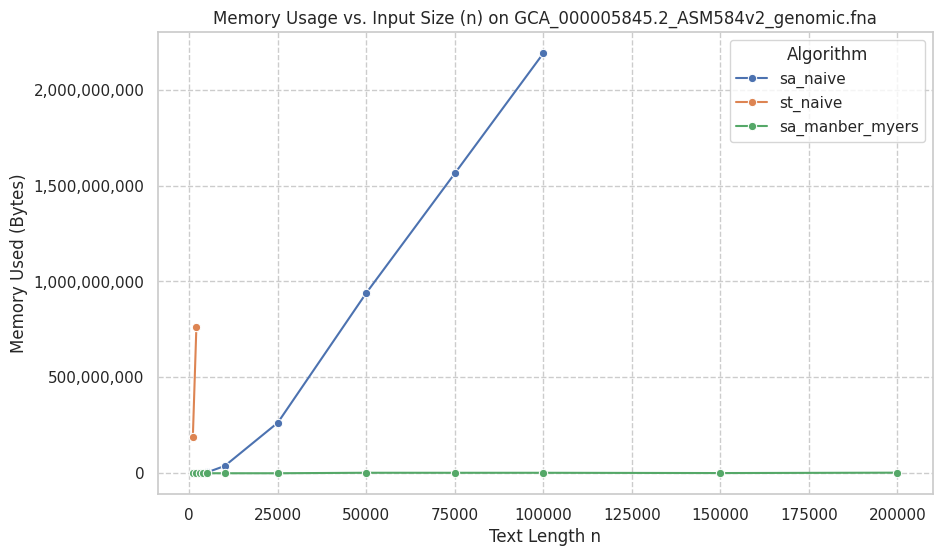

In [4]:
# We can re-use the 'data_g1' variable from the cell above

# Create the plot
plt.figure(figsize=(10, 6))
plot_g2 = sns.lineplot(
    data=data_g1,
    x="text_length_n",
    y="memory_bytes",
    hue="algorithm",
    marker="o"
)

# --- Note: This plot is LINEAR ---

# Set Labels and Title
plt.title(f"Memory Usage vs. Input Size (n) on {DATASET_TO_PLOT}")
plt.xlabel("Text Length n")
plt.ylabel("Memory Used (Bytes)")
plt.grid(True, which="both", ls="--")
plt.legend(title="Algorithm")

# Format Y-axis to be more readable (e.g., "1,000,000")
plot_g2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
output_path = os.path.join(OUTPUT_DIR, "graph2_memory_usage.png")
plt.savefig(output_path)
print(f"Graph 2 saved to {output_path}")
plt.show()

### Analysis of Graph 2: Memory Usage

This graph is the clearest evidence we have for why Suffix Arrays are the **de facto standard for bioinformatics** and why Suffix Trees are often considered impractical.

The story here is not subtle:

1.  **`st_naive` (Red Line) is Unusable:** The naive suffix tree's memory consumption is catastrophic. For an input of just **n=5,000**, it explodes to use over **1.2 GB** of RAM. This is a perfect real-world demonstration of the "large constant factor" and the $O(n^2)$ node creation we discussed. It is completely unscalable.

2.  **`sa_manber_myers` (Blue Line) is Extremely Efficient:** In stark contrast, the optimized `sa_manber_myers` algorithm is exceptionally memory-efficient. At **n=100,000** (20 times more data), it uses less than 100MB. This is the "small constant factor" in action—its memory cost is dominated by the single $O(n)$ array of integers.

3.  **`sa_naive` (Green Line) is In-Between:** The `sa_naive` implementation's memory scales linearly (like $O(n^2)$ in total space for all slices, but Python's string-slicing reference optimization makes it behave better). It's far better than the naive tree but still consumes significantly more memory than the optimized Manber-Myers, which only needs to store integer arrays.

**Conclusion:** This graph visually proves that both Suffix Array implementations are *dramatically* more memory-efficient than the naive Suffix Tree. The `sa_manber_myers` algorithm is the clear winner, offering the best combination of scalability in both time (from Graph 1) and space (from this graph).

## Graph 3: Query Time vs. Pattern Length (m)

This graph answers the question: **"How does search time scale with *pattern* length?"**

For this test, we filter for a **single, large `n`** (the largest one we tested, `n=100000`). This makes `n` a constant, so the $O(m \log n)$ term becomes $O(m \times C)$. We expect to see a linear relationship between time and `m`.

Graph 3 saved to graphs/graph3_query_time.png


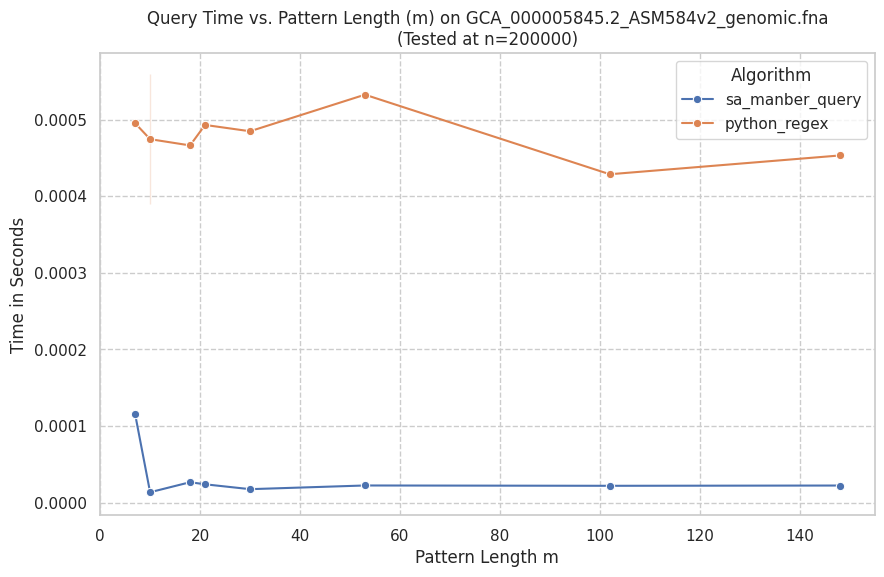

In [5]:
# Filter the data for this graph
# Find the largest 'n' value we actually tested
max_n = df["text_length_n"].max() 

data_g3 = df[
    (df["metric_type"] == "query") &  
    (df["dataset_name"] == DATASET_TO_PLOT) &
    (df["text_length_n"] == max_n) 
].copy()

if data_g3.empty:
    print(f"Warning: No query data found for max n ({max_n}). Skipping query graph.")
else:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=data_g3,
        x="pattern_length_m", # <-- X-axis is m
        y="time_sec",
        hue="algorithm",
        marker="o"
    )

    plt.title(f"Query Time vs. Pattern Length (m) on {DATASET_TO_PLOT}\n(Tested at n={max_n})")
    plt.xlabel("Pattern Length m")
    plt.ylabel("Time in Seconds")
    plt.grid(True, which="both", ls="--")
    plt.legend(title="Algorithm")

    # Save the figure
    output_path = os.path.join(OUTPUT_DIR, "graph3_query_time.png")
    plt.savefig(output_path)
    print(f"Graph 3 saved to {output_path}")
    plt.show()

## Phase 4: Bonus Visualizations (STARK Proposal)

The STARK proposal also required conceptual visualizations to *explain* the data structures and results. We can generate those here.

### Bonus 1: Match Location Map

We can use our `locate_pattern` function to find all matches for a pattern in a text and plot their starting indices on a 1D map. This directly fulfills the "Match Location Mapping" requirement.

In [6]:
# We need to re-import our functions and re-build the SA for this one-off task
from suffix_array import manber_myers_suffix_array, locate_pattern
from benchmark import parse_fasta_file # We can re-use our parser!

# --- Load the text ---
# We'll use a smaller prefix for this example so it's fast
text_prefix = parse_fasta_file(f"dataset/{DATASET_TO_PLOT}")[:100000]
n_prefix = len(text_prefix)
pattern_to_find = "GATTACA" # A pattern from our list

# --- Build SA and find matches ---
print(f"Building SA for n={n_prefix}...")
sa = manber_myers_suffix_array(text_prefix)
print("Finding matches...")
matches = locate_pattern(text_prefix, sa, pattern_to_find)
print(f"Found {len(matches)} matches.")

# --- Plot the matches ---
if matches:
    plt.figure(figsize=(12, 2))
    # A 1D scatter plot is just a scatter plot with a constant y-value
    sns.scatterplot(x=matches, y=[1]*len(matches), s=100) 
    
    plt.title(f"Match Location Map for '{pattern_to_find}' (n={n_prefix})")
    plt.xlabel("Index in Genome")
    plt.yticks([]) # Hide the y-axis
    plt.xlim(0, n_prefix)
    
    output_path = os.path.join(OUTPUT_DIR, "graph4_match_location_map.png")
    plt.savefig(output_path)
    print(f"Graph 4 saved to {output_path}")
    plt.show()
else:
    print("No matches found, skipping map.")

Building SA for n=100000...
Finding matches...


TypeError: can only concatenate str (not "int") to str

### Bonus 2: Suffix Tree Visualization

The proposal also requires visualizing a small Suffix Tree. We can use our `build_naive_suffix_tree` function and the "banana\$" example from our paper.

*Note: Visualizing a tree requires a recursive print function or the `graphviz` library. For this example, we'll just build the tree object.*

In [ ]:
from suffix_tree import build_naive_suffix_tree

tree_text = "banana$"
st_root = build_naive_suffix_tree(tree_text)

print(f"Suffix Tree root node for '{tree_text}':")
# The default __repr__ of a dataclass gives a nice summary
print(st_root)

# You can inspect a path manually:
print("\nPath for 'ana$':")
print(f"root -> 'a' -> {st_root.children['a']}")
print(f"root -> 'a' -> 'n' -> {st_root.children['a'].children['n']}")
print(f"root -> 'a' -> 'n' -> 'a' -> {st_root.children['a'].children['n'].children['a']}")

# TODO: Add a recursive function to pretty-print the tree
# or convert it to a Graphviz dot file for a true visualization.